# SET Dataset

Importiamo i dati dal dataset «[A multi-source dataset of urban life in the city of Milan and the Province of Trentino](https://www.nature.com/articles/sdata201555)». Il dataset contiene records di dati dall'infrastruttura delle telecomunicazioni, dati meteo, notizie, social networks e dati del consumo elettrico della città di Milano e della Provincia di Trento.

Intanto importiamo le librerie che ci serviranno.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon, MultiPolygon, MultiPoint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import pickle
import numpy as np
from shapely.ops import nearest_points
data_path = Path('data')

Poi importiamo i datasets in dataframe.

In [2]:
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson'}

def load_data(path):
    set1 = pd.read_csv(path / files['SET-1'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    set2 = pd.read_csv(path / files['SET-2'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    lines = pd.read_csv(path / files['SET-lines'])
    precip = pd.read_csv(path / files['precip'], names = ['TIMESTAMP','CELL_ID', 'INTENSITA'])
    precip_avail = pd.read_csv(path / files['precip-avail'], names = ['TIMESTAMP', 'AFFIDABILE'])
    with open(path / files['weather']) as f:
        meteo_json = json.load(f)
    meteo = gpd.GeoDataFrame(meteo_json['features'])
    meteo['geometry'] = meteo['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    meteo.drop(columns=['geomPoint.geom'], inplace=True)
    grid = gpd.read_file(path / files['grid'])
    with open(path / files['twitter']) as f:
        tweets_json = json.load(f)
    tweets = gpd.GeoDataFrame(tweets_json['features'])
    tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    tweets.drop(columns=['geomPoint.geom'], inplace=True)
    with open(path / files['adm_reg']) as f:
        regions_json = json.load(f)
    regions = gpd.GeoDataFrame(regions_json['items'])
    localunits = pd.read_csv(path / 'localunits.csv')
    localunitworkers = pd.read_csv(path / 'localunitworkers.csv')
    return set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, localunits, localunitworkers

In [3]:
set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, lu, luw = load_data(data_path)
set_tot = pd.concat([set1, set2], ignore_index=True)

## Preparare i Dati

Adesso prepariamo il dataset dei consumi elettrici. Per entrambi i dataset (di Novembre `SET-1` e di Dicembre `SET-2`) normalizziamo i consumi in rapporto al consumo totale della linea con un fattore dato dalle utenze presenti sulla linea nella cella, quindi restituiamo un GeoDataFrame con la geometria delle cellette e il consumo totale nella celletta.

In [4]:
def findnorm(df1, df2, row):
    return df1['NR_UBICAZIONI'][row] / df2.loc[df1['LINESET'][row]]

def get_cons_grid(setdf, linesdf, gridgdf):
    month_cons = setdf.groupby(['LINESET']).sum()
    # Troviamo il numero totale di utenze per linea
    lineuser = linesdf.groupby(['LINESET']).sum()['NR_UBICAZIONI']
    # Troviamo il fattore di normalizzazione
    linesdf['norm'] = [findnorm(linesdf, lineuser, row) for row in linesdf['NR_UBICAZIONI']]
    def findcons(df1, df2, row):
        try:
            result = df1['norm'][row] * df2.loc[df1['LINESET'][row]][0]
        except:
            result = None
        return result
    linesdf['cons'] = [findcons(linesdf, month_cons, row) for row in linesdf['NR_UBICAZIONI']]
    cellcons = linesdf.groupby(['SQUAREID'])[['cons']].sum()
    consgrid = pd.merge(gridgdf, cellcons, left_on='cellId', right_on='SQUAREID', how='left')
    return consgrid

In [5]:
consgrid = get_cons_grid(set_tot, lines, grid)
consgrid['geometry'] = consgrid['geometry'].centroid

La prossima parte l'abbiamo commentata perché l'esecuzione richiede molte risorse e l'importante è eseguirla una volta per avere i dati pronti per la regressione. Poiché non è possibile con le librerie attuali di Python selezionare una fascia oraria ogni giorno, ma soltanto un determinato intervallo tra ore specifiche di date specifiche, abbiamo ricavato manualmente gli indici che corrispondevano ai nostri orari di interesse (08:00-19:00 e 19:00-24:00) iterando sulle giornate.

In [6]:
# Listato da decommentare per produrre il dataframe con i consumi mediati per fasce orarie

#mylist = []
#for line in set_tot['LINESET'].unique():
#    firstday = set_tot['datetime'].iloc[0]
#    for day in range((set_tot.iloc[-1]['datetime'] - set_tot.iloc[0]['datetime']).days+1):
#        meancons1 = set_tot[set_tot['LINESET'] == line].iloc[day*144+48 : day*144+114].mean()[0]
#        meancons2 = set_tot[set_tot['LINESET'] == line].iloc[day*144+114 : (day+1)*144].mean()[0]
#        mylist.append([line, firstday+datetime.timedelta(days=day), meancons1, meancons2])

'\nListato da decommentare per produrre il dataframe con i consumi mediati per fasce orarie\n'

In [7]:
# Listato da decommentare per esportare il dataframe in csv oppure come file pkl

#df4 = pd.DataFrame(mylist)
#df4.to_csv('data/set_tot_data.csv')
#outfile = open('set_data.pkl', 'wb')
#pickle.dump(df4, outfile)
#outfile.close()

'\nListato da decommentare per esportare il dataframe in csv oppure come file pkl\n'

In [8]:
#set_data = pd.read_csv('data/set_tot_data.csv', index_col=0, names=['LINESET', 'date', 'early_cons', 'late_cons'], skiprows=[0])
infile = open('data/set_data.pkl', 'rb')
set_data=pickle.load(infile)
infile.close()

In [9]:
set_data.columns = ['LINESET', 'date', 'early_cons', 'late_cons']
lines1 = lines.copy().drop(columns='cons')

Adesso troviamoci il DataFrame che associa ad ogni data, ad ogni cella geografica il consumo nella fascia lavorativa, il consumo nella fascia non lavorativa ed il centroide.

In [10]:
setcons_date = pd.merge(set_data, lines, how='left', on='LINESET')
df5_1 = setcons_date.groupby(['date', 'LINESET']).apply(lambda x: (x['norm']*x['early_cons']).sum()).reset_index()
df5_1.columns = ['date', 'LINESET', 'norm_early_cons']
df5_2 = setcons_date.groupby(['date', 'LINESET']).apply(lambda x: (x['norm']*x['late_cons']).sum()).reset_index()
df5_2.columns = ['date', 'LINESET', 'norm_late_cons']
norm_cons = pd.concat([df5_1, df5_2], axis=1)
norm_cons = norm_cons.loc[:,~norm_cons.columns.duplicated()]
setcons_datecell = pd.merge(setcons_date, norm_cons, left_on=['LINESET', 'date'], right_on=['LINESET', 'date']).groupby(['SQUAREID', 'date']).sum().reset_index()
setcons_datecell.drop(columns=['early_cons', 'late_cons', 'NR_UBICAZIONI', 'norm', 'cons'], inplace=True)
setgrid_datecell = pd.merge(setcons_datecell, grid, left_on='SQUAREID', right_on='cellId')
setgrid_datecell.geometry = setgrid_datecell.geometry.apply(lambda x: x.centroid)

In [11]:
setgrid_datecell.head()

SQUAREID       date  norm_early_cons  norm_late_cons  cellId  \
0       155 2013-11-01        14.585304       26.075768     155   
1       155 2013-11-02        26.031270       26.609743     155   
2       155 2013-11-03        20.691523       23.942211     155   
3       155 2013-11-04        36.039039       28.628543     155   
4       155 2013-11-05        21.844423       25.078079     155   

                                      geometry  
0  POINT (10.92119335145374 45.68639714371787)  
1  POINT (10.92119335145374 45.68639714371787)  
2  POINT (10.92119335145374 45.68639714371787)  
3  POINT (10.92119335145374 45.68639714371787)  
4  POINT (10.92119335145374 45.68639714371787)

Esportiamo i dati per usi futuri.

In [12]:
outfile = open('data/setgrid_datecell.pkl', 'wb')
pickle.dump(setgrid_datecell,outfile)
outfile.close()

In [13]:
consperday_regA = set_data.groupby('date').sum().reset_index()
outfile = open('data/consperdayA.pkl', 'wb')
pickle.dump(consperday_regA,outfile)
outfile.close()

## Preparare i dati geografici e amministrativi

In [14]:
with open('data/tn_adm.json') as f:
    adm_json = json.load(f)
for d in adm_json['features']:
    d['geometry'] = shape(d['geometry'])
adm_gdf = gpd.GeoDataFrame(adm_json['features'])
adm = adm_gdf.from_features(adm_json['features'])
adm_red = adm[['geometry', 'name', 'com_catasto_code', 'com_istat_code']] # dataframe ridotto

In [15]:
population = pd.read_csv('data/tavola_pop_res01.csv')
population.columns = ['com_code', 'municipalities', 'm_pop', 'f_pop', 'tot_pop']
population['com_code'] = population['com_code'].apply(lambda x: int(x))

In [16]:
# Praticamente ci sono ancora alcuni dei comuni non accorpati (presumibilmente pre-2020)
with open('data/TavA25_2016.htm', 'r', encoding='ISO-8859-1') as file:
    localu = file.read().replace('\n', '')
localudf_raw = pd.read_html(localu)
localudf = localudf_raw[0][['Comuni', 'Industria in senso stretto', 'Costruzioni', 'Commercio, trasporti e pubblici esercizi', 'Altri servizi', 'Totale']]
localudf.columns = ['municipalities', 'industry', 'building', 'tertiary', 'other', 'total']
localudf = localudf.sort_values('municipalities')
col_list=['industry', 'building', 'tertiary', 'other', 'total']
localudf.loc[:, col_list] = localudf.loc[:, col_list].replace('-', 0)
localudf['building'] = localudf['building'].astype('int64')
localudf['industry'] = localudf['industry'].astype('int64')
newCityArr = ['Terre d\'Adige']
oldCitiesArr = [['Zambana', 'Nave San Rocco']]
for newCity, oldCities in zip(newCityArr, oldCitiesArr):
    dictNewCity = {'municipalities': newCity, **localudf[localudf['municipalities'].isin(oldCities)].sum(numeric_only=True).to_dict()}
    localudf = localudf.append((dictNewCity), ignore_index=True)
localudf = localudf[~localudf.municipalities.isin([val for sublist in oldCitiesArr for val in sublist])]

Eseguiamo un merge tra i tre dataset, in modo da ottenere un GeoDataFrame che contiene tutte le informazioni che ci servono. Inoltre eseguiamo un `sjoin` tra il GeoDataFrame appena ottenuto e il GeoDataFrame dei consumi per cella, scambiando la colonna `geometry` attualmente descritta dai quadrati con i propri centroidi e sommando i dati aggregati di consumo per ogni comune.

In [17]:
units_municip = pd.merge(adm_red, localudf, left_on='name', right_on='municipalities', how='left')
units_municip.crs = 'epsg:4326'
units_municip['com_code'] = units_municip['com_istat_code'].apply(lambda x: int(x))
#units_municip.plot('industry')
units_municip_pop = pd.merge(units_municip, population, how='left', left_on='com_code', right_on='com_code')
luconsraw_gdf = gpd.sjoin(units_municip_pop, consgrid, how='left')
luconsdf = pd.merge(localudf, luconsraw_gdf.groupby('name')[['cons', 'tot_pop']].sum(), how='left', left_on='municipalities', right_on='name')

## Preparare i dati per la regressione e la classificazione

Adesso puliamo i dati in modo da prepararli per la regressione e la classificazione. Trasformiamo le date in informazioni machine-readable, e associamo i tweet alle celle geografiche. Creiamo una colonna che contiene il numero cumulativo totale di tweets per cella per giornata.

In [18]:
tweets['datetime'] = tweets['created'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
tweets['weekday'] = tweets['datetime'].apply(lambda x: x.weekday())
tweets['date'] = tweets['datetime'].apply(lambda x: x.date())
tweets_red = tweets[['municipality.name', 'geometry', 'datetime', 'weekday', 'date']]
tweets_red['lat'], tweets_red['long'] = tweets['geometry'].x, tweets['geometry'].y
tweets.crs = 'epsg:4326'
grid.crs = 'epsg:4326'
tweetgrid_datecell = gpd.sjoin(tweets, grid, how='left', op='within').groupby(['cellId', 'date']).count()['timestamp'].reset_index()
tweetgrid_datecell.columns = ['cellId', 'date', 'tweetcount']

Abbiamo queste stazioni meteorologiche. Semplifichiamo il DataFrame `meteo` mediando sui dati delle precipitazioni per ottenere `mean_prec`, sui massimi e i minimi delle temperature per ottenere `mean_temp`, e sui massimi e i minimi del vento per ottenere `mean_wind`. Per associare i dati meteorologici ad ogni comune, possiamo eseguire un join collegando ad ogni comune il dato della stazione meteo con più vicina al centroide.

In [19]:
meteo_red = meteo[['station', 'elevation', 'date', 'timestamp', 'minTemperature', 'maxTemperature', 'minWind', 'maxWind', 'geometry']]
meteo_red_1 = meteo_red.copy()
meteo_red_1['mean_prec'] = meteo.filter(regex=("precipitations.*")).mean(axis=1)
meteo_red_1['mean_wind'] = meteo[['minWind', 'maxWind']].mean(axis=1)
meteo_red_1['mean_temp'] = meteo[['minTemperature', 'maxTemperature']].mean(axis=1)

In [20]:
meteo_red_1.drop(columns=['minTemperature', 'maxTemperature', 'minWind', 'maxWind'], inplace=True)
meteo_red_1.crs = 'epsg:4326'

In [21]:
def nearest_station(griddf, meteodf):
    nearest_arr = []
    df1 = griddf.copy()
    df2 = meteodf.copy()
    pts = df2.geometry.unary_union
    for idx, row in df1.iterrows():
        pt = row.geometry.centroid
        nearest_arr.append(nearest_points(pt, pts)[1])
    df3 = pd.Series(nearest_arr, name='nearest')
    df4 = pd.concat([df1,df3], axis=1)
    return df4

In [22]:
grid_nrst = nearest_station(grid, meteo).drop(columns='geometry')
grid_nrst.columns = ['cellId', 'geometry']
meteogrid_datecell = gpd.sjoin(grid_nrst, meteo_red_1, how='left', op='intersects')

In [23]:
outfile = open('data/meteogrid_datecell.pkl', 'wb')
pickle.dump(meteogrid_datecell, outfile)
outfile.close()

Ora mettiamo assieme `tweetgrid_datecell`, `setgrid_datecell` e `meteogrid_datecell`.

In [24]:
meteogrid_datecell = meteogrid_datecell[['cellId', 'date', 'mean_prec', 'mean_wind', 'mean_temp']]

In [25]:
oneday = datetime.timedelta(1)

### Preparazione dati per la Regressione

Riarrangiamo le informazioni nel DataFrame in modo che contengano abbiano 60 righe e tante colonne in più che rappresentano i consumi per singola cella per data. Questi ci serviranno per la regressione.

In [26]:
adm_red.crs = 'epsg:4326'
tncells = gpd.sjoin(grid, adm_red[adm_red['name'] == 'Trento'], op='intersects')[['cellId']]
tncells_list = (tncells.values.T.tolist()[0])

In [27]:
sgdc1 = setgrid_datecell[['date', 'norm_early_cons', 'norm_late_cons', 'cellId']].copy()
sgdc1.columns = ['date', 'pca', 'pcb', 'cellId'] # previous consumption a and b
sgdc1 = sgdc1.pivot(index='date', columns='cellId', values=['pca', 'pcb'])
sgdc1['pat_cons'] = sgdc1.sum(axis=1)
sgdc1['tn_cons'] = sgdc1.loc[:, (slice(None), tncells_list)].sum(axis=1)
sgdc1['pca'] = sgdc1['pca'].shift(periods=1)
sgdc1['pcb'] = sgdc1['pcb'].shift(periods=1)
sgdc1.loc['2013-11-01', :] = sgdc1.loc['2013-11-02',:].copy()
sgdc1.columns =[s1 + str(s2) for (s1,s2) in sgdc1.columns.tolist()]
sgdc1.reset_index(inplace=True)
sgdc1.head()

date     pca155     pca272     pca273      pca276      pca277  \
0 2013-11-01  14.585304  14.585304  14.585304   56.631025   56.631025   
1 2013-11-02  14.585304  14.585304  14.585304   56.631025   56.631025   
2 2013-11-03  26.031270  26.031270  26.031270   74.861560   74.861560   
3 2013-11-04  20.691523  20.691523  20.691523   64.536655   64.536655   
4 2013-11-05  36.039039  36.039039  36.039039  142.145393  142.145393   

      pca389     pca390      pca393     pca506  ...  pcb10980  pcb10981  \
0  14.585304  14.585304   56.631025  14.585304  ...  3.145741  3.145741   
1  14.585304  14.585304   56.631025  14.585304  ...  3.145741  3.145741   
2  26.031270  26.031270   74.861560  26.031270  ...  3.292060  3.292060   
3  20.691523  20.691523   64.536655  20.691523  ...  3.184689  3.184689   
4  36.039039  36.039039  142.145393  36.039039  ...  3.232690  3.232690   

   pcb10982  pcb10983  pcb10984  pcb11097  pcb11098  pcb11099       pat_cons  \
0  8.442657  5.296916  5.296916  3.145741  3.145741  3.145741  176140.243667   
1  8.442657  5.296916  5.296916  3.145741  3.145741  3.145741  176140.243667   
2  8.725471  5.433411  5.433411  3.292060  3.292060  3.292060  161647.247910   
3  8.594513  5.409823  5.409823  3.184689  3.184689  3.184689  207924.113704   
4  8.758881  5.526191  5.526191  3.232690  3.232690  3.232690  193472.206341   

        tn_cons  
0  13774.639250  
1  13774.639250  
2  13232.001240  
3  16673.634263  
4  16202.398468  

[5 rows x 3971 columns]

Ora prepariamo i dati per la regressione sul Comune di Trento.

In [28]:
sgdc2 = setgrid_datecell[['date', 'norm_early_cons', 'norm_late_cons', 'cellId']].copy()
sgdc2.columns = ['date', 'pca', 'pcb', 'cellId'] # previous consumption a and b
sgdc2 = sgdc2.pivot(index='date', columns='cellId', values=['pca', 'pcb'])
#sgdc2['pat_cons'] = sgdc2.sum(axis=1)
sgdc2 = sgdc2.loc[:, (slice(None), tncells_list)]

In [29]:
sgdc2['tn_cons'] = sgdc2.sum(axis=1)
sgdc2['pca'] = sgdc2['pca'].shift(periods=1)
sgdc2['pcb'] = sgdc2['pcb'].shift(periods=1)
sgdc2.loc['2013-11-01', :] = sgdc2.loc['2013-11-02',:].copy()
sgdc2.columns =[s1 + str(s2) for (s1,s2) in sgdc2.columns.tolist()]
sgdc2.reset_index(inplace=True)
sgdc2.head()

date    pca4030    pca4031    pca4145    pca4146    pca4147  \
0 2013-11-01  41.694399  41.694399  50.965561  50.965561  41.694399   
1 2013-11-02  41.694399  41.694399  50.965561  50.965561  41.694399   
2 2013-11-03  43.153952  43.153952  51.328986  51.328986  43.153952   
3 2013-11-04  39.017625  39.017625  49.181725  49.181725  39.017625   
4 2013-11-05  62.411181  62.411181  73.972333  73.972333  62.411181   

     pca4148    pca4263     pca4264    pca4265  ...    pcb6020    pcb6021  \
0  41.694399  50.965561   92.659960  41.694399  ...  25.849352  25.849352   
1  41.694399  50.965561   92.659960  41.694399  ...  25.849352  25.849352   
2  43.153952  51.328986   94.482938  43.153952  ...  26.865463  26.865463   
3  39.017625  49.181725   88.199350  39.017625  ...  27.587283  27.587283   
4  62.411181  73.972333  136.383514  62.411181  ...  29.382316  29.382316   

     pcb6136    pcb6137    pcb6138    pcb6253    pcb6254    pcb6255  \
0  41.125464  43.691654  25.849352  39.529915  42.096105  42.096105   
1  41.125464  43.691654  25.849352  39.529915  42.096105  42.096105   
2  44.336298  45.447355  26.865463  41.888740  42.999797  42.999797   
3  43.433902  45.688104  27.587283  39.014999  41.269201  41.269201   
4  48.935981  49.647503  29.382316  46.038680  46.750201  46.750201   

     pcb6256       tn_cons  
0  42.096105  13774.639250  
1  42.096105  13774.639250  
2  42.999797  13232.001240  
3  41.269201  16673.634263  
4  46.750201  16202.398468  

[5 rows x 296 columns]

In [30]:
meteogrid_datecell['date'] = meteogrid_datecell['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'))
tweetgrid_datecell['date'] = tweetgrid_datecell['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'))

In [31]:
#df6_1 = pd.merge(tweetgrid_datecell, sgdc1, how='outer', left_on=['cellId', 'date'], right_on=['cellId', 'date']).fillna(0)
total_datecell = pd.merge(tweetgrid_datecell, meteogrid_datecell, how='outer', left_on=['cellId', 'date'], right_on=['cellId', 'date'])
total_datecell = total_datecell[['date', 'cellId', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp']]
tdc1 = total_datecell.groupby('date').sum().reset_index()[['date', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp']]
tot_df = pd.concat([tdc1, sgdc1], axis=1)
tot_df = tot_df.loc[1:,~tot_df.columns.duplicated()]
tot_df['weekday'] = tot_df['date'].apply(lambda x: x.weekday())

### Esportazione dati per la Classificazione

Esportiamo il dataset che verrà poi usato nella classificazione.

In [32]:
outfile = open('data/total_datecell0.pkl', 'wb')
pickle.dump(total_datecell, outfile)
outfile.close()

### Esportazione dati per la Regressione

In [33]:
tdc2 = total_datecell[(total_datecell['cellId'].isin(tncells_list))].groupby('date').sum().reset_index()[['date', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp']]
tn_df = pd.concat([tdc2, sgdc2], axis=1)
tn_df = tn_df.loc[1:,~tn_df.columns.duplicated()]
tn_df['weekday'] = tn_df['date'].apply(lambda x: x.weekday())

In [34]:
outfile = open('data/tot_df.pkl', 'wb')
pickle.dump(tot_df, outfile)
outfile.close()
outfile = open('data/tn_df.pkl', 'wb')
pickle.dump(tn_df, outfile)
outfile.close()

## Exploratory Data Analysis

Nella nostra EDA cerchiamo di comprendere la correlazione tra zone industrializzate, zone ad alta densità abitativa e i consumi elettrici del mese di Novembre. Utilizziamo dei dataset diversi da quelli forniti, visto che erano aggiornati al 2011 e quindi non contemplavano le soppressioni e le unioni dei comuni fatte nel frattempo. I dati delle divisioni amministrative sono quelli di OpenPolis, i dati della popolazione di I.Stat e i dati delle unità di lavoratori dell'ISPAT. Usiamo invece i dataset forniti per quanto riguarda i consumi elettrici (SET), i dati social (Twitter) e i dati meteorologici (MeteoTrentino).

Visto che non stiamo facendo alcuna ipotesi determinante per le successive regressioni e classificazioni, ma vogliamo solamente visualizzare alcune proprietà dei dataset forniti, utilizziamo i dataset nella loro *full extent*. L'Exploratory Data Analysis vera e propria, utile ai fini della regressione e della classificazione, verranno eseguite nei rispettivi notebook.

Otteniamo allora i plot dei **consumi totali** dei mesi di Novembre e Dicembre.

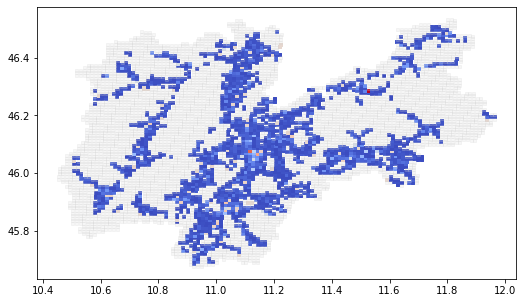

In [71]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
consgrid.plot('cons', marker='s', markersize=9, cmap='coolwarm', ax=ax1, missing_kwds= dict(color = "lightgrey", markersize=9, marker='s', alpha=.2))
plt.show()

Finora abbiamo cercato di visualizzare i consumi totali dei mesi di Novembre e Dicembre in Trentino. Ora visualizziamo prima di tutto, per tutte le linee, il consumo medio per giorno della settimana per cercare delle tendenze.

In [42]:
def plotWeekAvgLine(setdf, start, end):
    setdf['datetime'] = pd.to_datetime(setdf['TIMESTAMP'])
    setdf_copy = setdf[((setdf['datetime'] >= np.datetime64(start)) & (setdf['datetime'] < np.datetime64(end)))]
    setdf_copy['weekday'] = setdf_copy['datetime'].apply(lambda x: x.strftime('%A'))
    setdf_copy['time'] = [d.time() for d in setdf_copy['datetime']]
    setdf_copy_1=setdf_copy.groupby(['weekday', 'time']).mean()
    ax1 = plt.gca()
    ax1.grid()
    daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for dd in daysofweek:
        setdf_copy_1.iloc[setdf_copy_1.index.get_level_values('weekday') == dd].plot(ax = ax1, label=dd)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)
    ax1.legend(daysofweek, loc='best')
    ax1.grid()
    ax1.set_xticklabels(['00:00', '00:00', '03:20', '06:40', '10:00', '13:20', '16:40', '20:00', '23:20'])
    ax1.set_xlabel('time of the day [hh:mm]')
    ax1.set_ylabel('power consumption')

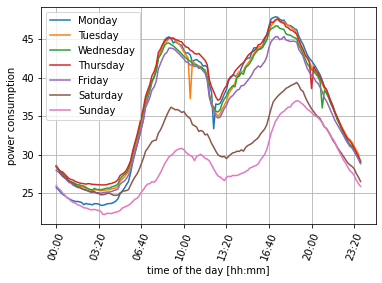

In [43]:
plotWeekAvgLine(set_tot, '2013-11-01 00:00', '2013-12-31 23:50')
plt.show()

Vediamo chiaramente da questo grafico come ci siano sostanzialmente dei consumi molto simili, in media, per i giorni feriali (Lunedì, Martedì, Mercoledì, Giovedì e Venerdì), un consumo più basso il Sabato e un consumo ancora minore di Domenica.

Adesso visualizziamo le informazioni dei dataset dei tweets e del meteo. La seguente figura rappresenta la densità di tweets tra Novembre 2013 e Dicembre 2013.

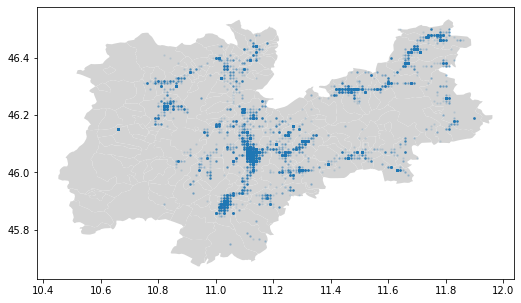

In [44]:
fig, ax4 = plt.subplots(1,1,figsize=(10,5))
adm.plot(ax=ax4, color='lightgrey')
tweets.plot(markersize=2, alpha=.1, ax=ax4)

Possiamo notare come la densità di attività su Twitter sia concentrata molto nelle aree urbane (ad esempio Trento, Rovereto, Pergine e Cles) ma vi siano anche dei "cluster" di attività nelle zone montuose tipicamente destinazioni sciistiche, come la Val di Fassa, Madonna di Campiglio e la Val di Sole.

I seguenti punti rappresentano invece le **stazioni meteorologiche**.

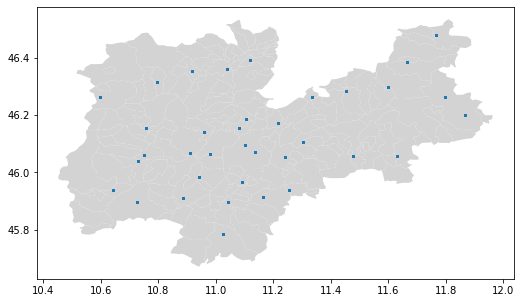

In [45]:
fig, ax3 = plt.subplots(1,1,figsize=(10,5))
adm.plot(ax=ax3, color='lightgrey')
meteo.plot(markersize=2, ax=ax3)

## Correlazione tra comuni industriali e consumo elettrico

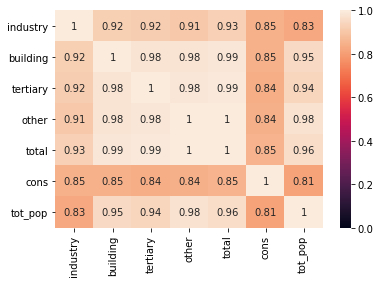

In [46]:
luconsCorr = luconsdf.corr()
sns.heatmap(luconsCorr, annot=True, vmin=0)
plt.show()

Come richiesto, vediamo come in realtà tutte le variabili considerate (addetti nel settore industriale, nel settore delle costruzioni, nel terziario, in altri settori, la popolazione totale ed i consumi elettrici) siano molto correlate tra loro. Sicuramente quindi luoghi con grandi consumi di elettricità corrispondono in buona approssimazione con luoghi ad alta densità abitativa e con luoghi con tanti lavoratori.

In [47]:
tweets_regA_count = tweets_red[['datetime', 'date']].groupby('date').count().reset_index()

In [48]:
tweets_loc_df = tweets_red[['date', 'lat', 'long']].groupby('date').mean().reset_index()
tweets_regA_loc = gpd.GeoDataFrame(tweets_loc_df, geometry=gpd.points_from_xy(tweets_loc_df.lat, tweets_loc_df.long))
tweets_regA_loc['day'] = (tweets_regA_loc['date'] - tweets_regA_loc['date'].iloc[0]).dt.days
tweets_regA_loc.crs = 'epsg:4326'

Nella prossima figura vediamo, dai colori freddi ai colori caldi in senso cronologico, il passaggio temporale da inizio Novembre a fine Dicembre del baricentro di pubblicazione dei tweets. Questa informazione non è utile ai fini della nostra elaborazione, tuttavia è interessante notare come progressivamente si sposti da sud-ovest a nord-est!

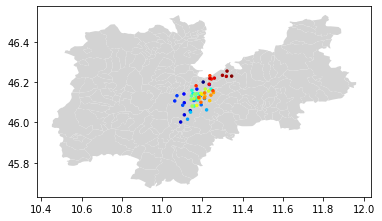

In [49]:
fig, ax5 = plt.subplots()
adm_red.plot(color='lightgrey', ax=ax5)
tweets_regA_loc.plot(markersize=6, c='day', cmap=plt.get_cmap('jet'), ax=ax5)

In [50]:
meteo_regA = meteo_red_1[['date', 'mean_prec', 'mean_wind', 'mean_temp', 'station']].groupby('date').mean().reset_index()
meteo_geom = meteo_red_1[['station', 'geometry']]

In [51]:
mean_tweet_loc = pd.DataFrame()
tweets_count = pd.DataFrame()
mean_tweet_loc['tweetlat'], mean_tweet_loc['tweetlong'] = tweets_regA_loc['lat'], tweets_regA_loc['long']
tweets_count['tweetcount'] = tweets_regA_count['datetime'].copy()
meteo_regA_red = meteo_regA[['mean_prec', 'mean_wind', 'mean_temp']]
regA_df = pd.concat([consperday_regA, mean_tweet_loc, tweets_count, meteo_regA_red], axis=1)
regA_df.drop(regA_df.tail(1).index,inplace=True)
regA_df['day'] = regA_df['date'].apply(lambda x: x.weekday())#apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

In [52]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
weekday_1hot = encoder.fit_transform(regA_df['day'])
weekday_1hot_df = pd.DataFrame(weekday_1hot)
weekday_1hot_df.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
regA_df_1 = pd.concat([regA_df, weekday_1hot_df], axis=1)

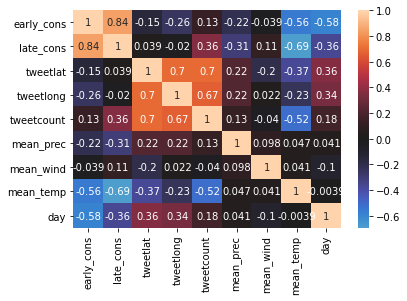

In [53]:
sns.heatmap(regA_df.corr(), annot=True, center=0)
plt.show()

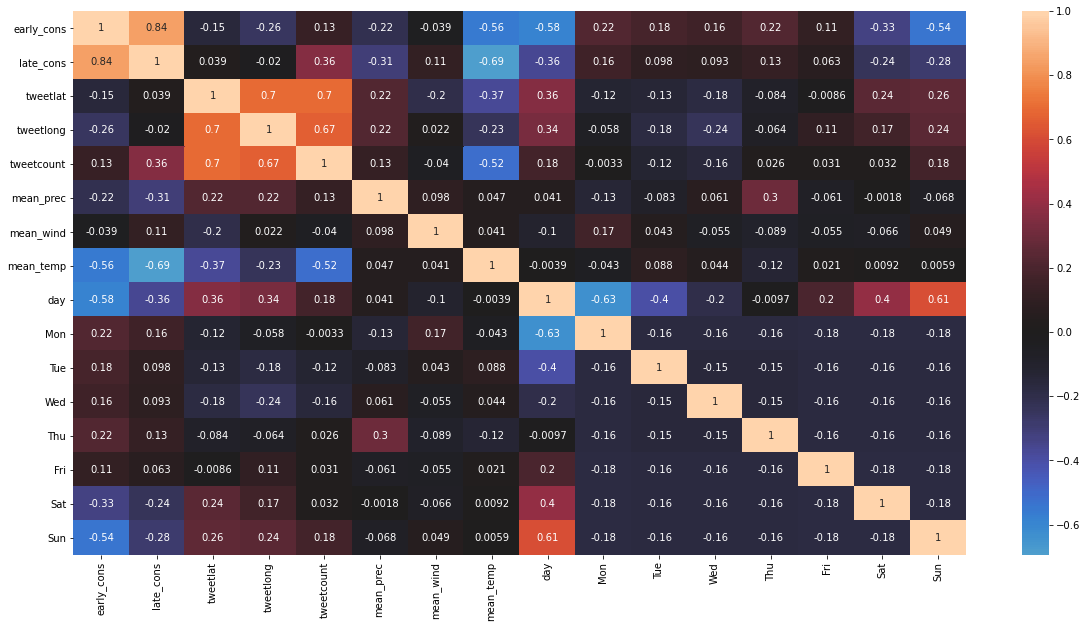

In [54]:
plt.figure(figsize=(20, 10))
sns.heatmap(regA_df_1.corr(), annot=True, center=0)
plt.show()

Qualche osservazione sulle correlazioni:

- Vediamo come i consumi della fascia oraria 08:00-19:00 siano correlati con un coefficiente di -0.58 al giorno della settimana, mentre i consumi della fascia oraria 19:00-24:00 sono correlati con coefficiente -0.36. Questo sta a significare che evidentemente i consumi elettrici in fascia tarda sono molto più equidistribuiti durante la settimana, mentre i consumi in fascia "orario di lavoro" dipendono molto di più dal giorno della settimana. Questo riflette il fatto che nei giorni feriali le industrie e le attività commerciali sono aperte e consumano una maggiore quantità di energia elettrica. In particolare il segno negativo segnala una tendenza ad un consumo minore di elettricità nei fine settimana.
- Un'altra correlazione degna di nota avviene tra i consumi e la temperatura media. Evidentemente l'uso di impianti termici e di riscaldamento durante la giornata porta ad un consumo maggiore di energia elettrica: l'anticorrelazione denotata dalla costante -0.56 sta a significare che con temperature più alte è più ridotto il consumo elettrico.

In [55]:
outfile = open('data/regA_data.pkl', 'wb')
pickle.dump(regA_df_1, outfile)
outfile.close()